## 3. Structure discovery for the Lorenz-96 problem

In this notebook, we will show how we can estimate the conditional independence structure of a random variable $\mathsf{X} \in \mathbb{R}^{N_x}$ with density $\pi$ based on i.i.d. samples $\{\boldsymbol{x}^i\}, \; i = 1, \ldots, N_e$ from $\pi$.

Reference: 

[1] Lorenz, E.N., 1996, September. Predictability: A problem partly solved. In Proc. Seminar on predictability (Vol. 1, No. 1).

[2] Baptista, R., Zahm, O., & Marzouk, Y. (2020). An adaptive transport framework for joint and conditional density estimation. arXiv preprint arXiv:2009.10303.

[3] Baptista, R., Marzouk, Y., Morrison, R.E. and Zahm, O., 2021. Learning non-Gaussian graphical models via Hessian scores and triangular transport. arXiv preprint arXiv:2101.03093.


In [1]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using OrdinaryDiffEq
using ProgressMeter

┌ Info: Precompiling AdaptiveTransportMap [bdf749b0-1400-4207-80d3-e689c0e3f03d]
└ @ Base loading.jl:1278
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116


Load some packages to make nice figures

In [2]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

The Lorenz-96 model [1] is a famous problem used in data assimilation and weather prediction. It was derived from first principles as a one-dimensional model for the response of the mid-latitude atmosphere to forcing input. For certain forcing input, it can exhibit a chaotic behavior: sensitivity to initial conditions, strong mixing. In this notebook, we consider the fifteen-dimensional version of the Lorenz-96 model.  The state $\boldsymbol{x} = (x_1, \ldots, x_{15})$ at time $t$ is governed by the following set of ordinary differential equations:  

\begin{equation}
    \frac{\mathrm{d}x_i}{\mathrm{d}t} = (x_{i+1} - x_{i-2}) x_{i-1} -x_i + F,
\end{equation}
where it is assumed that $x_{-1} = x_{n − 1} , x_0 = x_{n}$ and $x_{n+1} = x_1$, setting the forcing input $F=8.0$ leads to chaos.

We integrate the Lorenz-96 problem with our favorite ODE library: OrdinaryDiffEq.jl.

In [3]:
function lorenz96!(du,u,p,t)
    F = 8.0
    n = size(u,1)
    du[1] = (u[2]-u[end-1])*u[end] - u[1] + F
    du[2] = (u[3]-u[end])*u[1] - u[2] + F
    du[end] = (u[1] - u[end-2])*u[end-1] - u[end] + F

    @inbounds for i=3:n-1
        du[i] = (u[i+1] - u[i-2])*u[i-1] - u[i] + F
    end
    return du
end

lorenz96! (generic function with 1 method)

In [4]:
# Define the distribution for initial condition
Nx = 15
# Number of runs
Ne = 500
πx0 = MvNormal(zeros(Nx), ones(Nx))
# Zero vector of the size of the state
x0 = rand(πx0)

# Time stepp
tspan = (0.0, 500.0)
prob = ODEProblem(lorenz96!,x0, tspan)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 500.0)
u0: [1.3164312116825965, -0.00937087101794596, 0.31820025807609204, -0.8577783560470443, 2.233565382578525, 0.08239942620688392, -0.587306891375733, 1.6877118200543608, -0.9479697233951918, 0.388883994965015, -2.0284047334128372, -0.22315109074528808, -1.8928420713782987, 0.06159238886873483, 1.274952784582171]

Create cache to store the different final solutions

In [5]:
X = zeros(Nx, Ne);

Solve Lorenz-96 model for the different initial conditions and store the solutions as the columns of `X`

In [6]:
@inbounds for i=1:Ne
    prob = remake(prob; u0 = rand(πx0))
    sol = solve(prob, Tsit5(), dt = 0.01, adaptive = false, dense = false, saveat = tspan[end], save_start = false)
    X[:,i] = deepcopy(sol.u[1])
end

We can use the adaptive transport map procedure to estimate the underlying distribution for the state $\mathsf{X}$.

In [7]:
m = 60
S = HermiteMap(m, X; diag = true);

The optimization procedure takes about 5 minutes with $N_e = 500$ samples

In [8]:
optimize(S, X, "kfold"; withqr = true, verbose = true, hessprecond = true)

1 terms - Training error: 1.4189072092603516, Validation error: 1.4140638289819571
1 terms - Training error: 1.4189046575630833, Validation error: 1.4142302169990089
2 terms - Training error: 1.4156100490471921, Validation error: 1.4136804953962758
3 terms - Training error: 1.4142801326750076, Validation error: 1.4077381102803375
4 terms - Training error: 1.4068900977575602, Validation error: 1.409670919770262
5 terms - Training error: 1.4062627998389383, Validation error: 1.4118654608571566
6 terms - Training error: 1.401916125063904, Validation error: 1.4025037098062443
7 terms - Training error: 1.401624407319526, Validation error: 1.4008339423232112
8 terms - Training error: 1.4015506460952043, Validation error: 1.399754412023711
9 terms - Training error: 1.4015234722254266, Validation error: 1.400977672307081
10 terms - Training error: 1.3991370215011838, Validation error: 1.4079561323913075
11 terms - Training error: 1.399123863282832, Validation error: 1.4077919108785413
12 terms

12 terms - Training error: 1.387865550601966, Validation error: 1.466166262373065
13 terms - Training error: 1.3876997390449428, Validation error: 1.4669708605051475
14 terms - Training error: 1.3875912153807888, Validation error: 1.4683002813359654
15 terms - Training error: 1.3875684548227396, Validation error: 1.4684725715124718
16 terms - Training error: 1.386948331316466, Validation error: 1.473994321702739
17 terms - Training error: 1.38651470854148, Validation error: 1.4764836264801413
18 terms - Training error: 1.38604610582026, Validation error: 1.4817116941927535
19 terms - Training error: 1.3852796569100392, Validation error: 1.4838342044071575
20 terms - Training error: 1.3852543043020178, Validation error: 1.4844636979766728
21 terms - Training error: 1.3844532454692917, Validation error: 1.4859429121265162
22 terms - Training error: 1.384384609947607, Validation error: 1.4858536465261238
23 terms - Training error: 1.3839215565644227, Validation error: 1.487148087106967
1 

Progress:   7%|██▊                                      |  ETA: 0:01:35

1 terms - Training error: 1.4304061453748926, Validation error: 1.3680680845237947
1 terms - Training error: 1.4293504366041498, Validation error: 1.3672012004215877
2 terms - Training error: 1.4263742586309065, Validation error: 1.3698696589981658
3 terms - Training error: 1.4005410646853063, Validation error: 1.36239623510666
4 terms - Training error: 1.3976698404318597, Validation error: 1.3716417385095414
5 terms - Training error: 1.3955199305807093, Validation error: 1.3750152563875053
6 terms - Training error: 1.394768572379197, Validation error: 1.3711861348920829
7 terms - Training error: 1.3928039608174596, Validation error: 1.3666931312251884
8 terms - Training error: 1.3913614327416584, Validation error: 1.358290215272002
9 terms - Training error: 1.39044428575349, Validation error: 1.3668371710800395
10 terms - Training error: 1.3804991468281957, Validation error: 1.3646965089550622
11 terms - Training error: 1.37839011886075, Validation error: 1.364437349444257
12 terms - 

12 terms - Training error: 1.3300811261062921, Validation error: 1.4242819080667872
13 terms - Training error: 1.3298968150287005, Validation error: 1.4224058576924279
14 terms - Training error: 1.3278213974198394, Validation error: 1.4466441455304495
15 terms - Training error: 1.3264856753383272, Validation error: 1.440785487288356
16 terms - Training error: 1.3259540737297826, Validation error: 1.4454844117535133
17 terms - Training error: 1.3255805962663045, Validation error: 1.450146766739632
18 terms - Training error: 1.3254883552831693, Validation error: 1.452463603051121
19 terms - Training error: 1.3253365609258774, Validation error: 1.4557234502160876
20 terms - Training error: 1.3251302641433562, Validation error: 1.4563991434898933
21 terms - Training error: 1.325053067604745, Validation error: 1.458142004291163
22 terms - Training error: 1.324970674011749, Validation error: 1.4562758554078716
23 terms - Training error: 1.3248446120784778, Validation error: 1.455794972597833

Progress:  13%|█████▌                                   |  ETA: 0:00:57

1 terms - Training error: 1.420032514866291, Validation error: 1.409562606558199
1 terms - Training error: 1.4186501980259243, Validation error: 1.4098862216954002
2 terms - Training error: 1.4069056208758794, Validation error: 1.3953526181000586
3 terms - Training error: 1.4053471706719602, Validation error: 1.392345870414693
4 terms - Training error: 1.3992094084310778, Validation error: 1.375637557112164
5 terms - Training error: 1.3796936518273175, Validation error: 1.366894632114186
6 terms - Training error: 1.2938282481825738, Validation error: 1.269917974134147
7 terms - Training error: 1.290307231558464, Validation error: 1.265361985898647
8 terms - Training error: 1.2899063751066733, Validation error: 1.2656813302266574
9 terms - Training error: 1.2895066816764738, Validation error: 1.2660200389174177
10 terms - Training error: 1.2874923808116254, Validation error: 1.2681693983377664
11 terms - Training error: 1.2812531339815365, Validation error: 1.277012188602065
12 terms - 

8 terms - Training error: 1.2822568487736965, Validation error: 1.3014300781693517
9 terms - Training error: 1.2805364426285373, Validation error: 1.3119563178817593
10 terms - Training error: 1.2456464921253845, Validation error: 1.30451634345735
11 terms - Training error: 1.2453500883302566, Validation error: 1.305467588524061
12 terms - Training error: 1.244769831204206, Validation error: 1.3007971891653545
13 terms - Training error: 1.237400012578519, Validation error: 1.311572127785222
14 terms - Training error: 1.2357283507698007, Validation error: 1.3113411245319284
15 terms - Training error: 1.2350561958403201, Validation error: 1.3036250965218312
16 terms - Training error: 1.2334185139618967, Validation error: 1.3129498484988535
17 terms - Training error: 1.2291682967000916, Validation error: 1.324778970035445
18 terms - Training error: 1.2227949580524982, Validation error: 1.3259395402620626
19 terms - Training error: 1.21625220337007, Validation error: 1.3328753708853063
20 

Progress:  20%|████████▎                                |  ETA: 0:00:43

22 terms - Training error: 1.2168439259107517
1 terms - Training error: 1.437198183932451, Validation error: 1.340899930293558
1 terms - Training error: 1.4356719250357346, Validation error: 1.3416407768041259
2 terms - Training error: 1.428609002333438, Validation error: 1.342195558345588
3 terms - Training error: 1.4073488664394054, Validation error: 1.3208167999996274
4 terms - Training error: 1.4014943937896904, Validation error: 1.3170874991153116
5 terms - Training error: 1.3914338932240915, Validation error: 1.296582170569912
6 terms - Training error: 1.3026217534467457, Validation error: 1.2210518097581706
7 terms - Training error: 1.296224606928967, Validation error: 1.2173371277341425
8 terms - Training error: 1.290234700885706, Validation error: 1.1974820536917934
9 terms - Training error: 1.2898540028352568, Validation error: 1.200577692068104
10 terms - Training error: 1.2790157104021846, Validation error: 1.1799389582611364
11 terms - Training error: 1.2785716157465188, V

3 terms - Training error: 1.3950918851252196, Validation error: 1.3551462106507663
4 terms - Training error: 1.3888390712006, Validation error: 1.3516294343339574
5 terms - Training error: 1.3016218585606576, Validation error: 1.2551290367981114
6 terms - Training error: 1.2974918876157817, Validation error: 1.2447456503643526
7 terms - Training error: 1.2908023518011489, Validation error: 1.2345995923023922
8 terms - Training error: 1.27733545066397, Validation error: 1.2353926421355044
9 terms - Training error: 1.2744725011315985, Validation error: 1.2497458742173742
10 terms - Training error: 1.2717022973420231, Validation error: 1.2377445762320363
11 terms - Training error: 1.2617569396731758, Validation error: 1.2495054771034826
12 terms - Training error: 1.2511363294814937, Validation error: 1.2394266525025397
13 terms - Training error: 1.2463329744658802, Validation error: 1.2309939245142367
14 terms - Training error: 1.2435991393760657, Validation error: 1.228842123765838
15 te

Progress:  27%|██████████▉                              |  ETA: 0:00:37

24 terms - Training error: 1.1981324683705068
1 terms - Training error: 1.4006558506018534, Validation error: 1.4870692636159493
1 terms - Training error: 1.397989028887204, Validation error: 1.4949866479438827
2 terms - Training error: 1.3910476004019212, Validation error: 1.4990760473632287
3 terms - Training error: 1.3732978107642324, Validation error: 1.485892465479383
4 terms - Training error: 1.3711959767208366, Validation error: 1.484985529674096
5 terms - Training error: 1.3202361563748322, Validation error: 1.419879393599552
6 terms - Training error: 1.3191893614002979, Validation error: 1.4192396861936856
7 terms - Training error: 1.3184979573859024, Validation error: 1.4251950766361385
8 terms - Training error: 1.317585761301154, Validation error: 1.4258903962899192
9 terms - Training error: 1.3164297922337354, Validation error: 1.4247565861248304
10 terms - Training error: 1.3152418347402117, Validation error: 1.4373325147718639
11 terms - Training error: 1.3149938589920642

10 terms - Training error: 1.3367430778747726, Validation error: 1.345070908845007
11 terms - Training error: 1.3360566439282395, Validation error: 1.3427809920330211
12 terms - Training error: 1.3328942681444627, Validation error: 1.3436746090120804
13 terms - Training error: 1.33031267183825, Validation error: 1.3575222040435893
14 terms - Training error: 1.3245490015316832, Validation error: 1.3494065561115005
15 terms - Training error: 1.324202888811594, Validation error: 1.3495407917017619
16 terms - Training error: 1.3217750702901476, Validation error: 1.349415861821353
17 terms - Training error: 1.3209741740703702, Validation error: 1.3565870073567772
18 terms - Training error: 1.3075520265421252, Validation error: 1.3504502102365243
19 terms - Training error: 1.2950599982904656, Validation error: 1.3443590454175118
20 terms - Training error: 1.28395395551342, Validation error: 1.3346345724377915
21 terms - Training error: 1.2786443573173711, Validation error: 1.3146598676024832

Progress:  33%|█████████████▋                           |  ETA: 0:00:33

21 terms - Training error: 1.262067563432326
22 terms - Training error: 1.2619091212438684
1 terms - Training error: 1.4144749990878627, Validation error: 1.4317926696719128
1 terms - Training error: 1.412012296717685, Validation error: 1.4372115386322621
2 terms - Training error: 1.4077280974510553, Validation error: 1.4215417219836948
3 terms - Training error: 1.3814106575256915, Validation error: 1.4038911504002314
4 terms - Training error: 1.3607315428205617, Validation error: 1.383083378069686
5 terms - Training error: 1.2869475602692144, Validation error: 1.3192065152003056
6 terms - Training error: 1.2843242362450153, Validation error: 1.312348878340993
7 terms - Training error: 1.2834755843426353, Validation error: 1.3100041519054315
8 terms - Training error: 1.2779405888193698, Validation error: 1.3124680477619868
9 terms - Training error: 1.2771334894197202, Validation error: 1.3103954287083974
10 terms - Training error: 1.2768154103644354, Validation error: 1.310510782755396

9 terms - Training error: 1.2798615003471283, Validation error: 1.307653343646325
10 terms - Training error: 1.2767274199944554, Validation error: 1.3041243852118356
11 terms - Training error: 1.2759028753388768, Validation error: 1.302977571269648
12 terms - Training error: 1.2723595367015077, Validation error: 1.3113732945901868
13 terms - Training error: 1.26930715842002, Validation error: 1.3171474710629454
14 terms - Training error: 1.2673238208330533, Validation error: 1.3265465931302263
15 terms - Training error: 1.265384964954473, Validation error: 1.3346350468674195
16 terms - Training error: 1.2645233457728664, Validation error: 1.33021482867327
17 terms - Training error: 1.2619243538654914, Validation error: 1.3186768105202111
18 terms - Training error: 1.2609651951184648, Validation error: 1.3184498915331802
19 terms - Training error: 1.2584738031965812, Validation error: 1.3184007903981425
20 terms - Training error: 1.2576503440545697, Validation error: 1.3225630011251064


Progress:  40%|████████████████▍                        |  ETA: 0:00:28

18 terms - Training error: 1.2730308423613756
19 terms - Training error: 1.2692720003887765
20 terms - Training error: 1.2685242008373623
1 terms - Training error: 1.4253743944437465, Validation error: 1.3881950882483753
1 terms - Training error: 1.423948322427547, Validation error: 1.3914707632199494
2 terms - Training error: 1.4079337717340175, Validation error: 1.3723221298018913
3 terms - Training error: 1.3926639139865593, Validation error: 1.362336336442462
4 terms - Training error: 1.3771533945472245, Validation error: 1.328207401044792
5 terms - Training error: 1.37393212550116, Validation error: 1.3321927470164383
6 terms - Training error: 1.3686750243932422, Validation error: 1.3215347830951132
7 terms - Training error: 1.3650914407149888, Validation error: 1.334212142265764
8 terms - Training error: 1.3649059033526705, Validation error: 1.3325288724351496
9 terms - Training error: 1.36320753431452, Validation error: 1.3245135373308288
10 terms - Training error: 1.29419838756

12 terms - Training error: 1.2776190701409667, Validation error: 1.2918244095574272
13 terms - Training error: 1.2769435982355253, Validation error: 1.2894299240092262
14 terms - Training error: 1.2757173745303194, Validation error: 1.292294146018687
15 terms - Training error: 1.2647689920210161, Validation error: 1.2984208738978416
16 terms - Training error: 1.2436741728490317, Validation error: 1.2946856460019713
17 terms - Training error: 1.2421339765895318, Validation error: 1.2943908038239154
18 terms - Training error: 1.2311033039491737, Validation error: 1.2964836078248843
19 terms - Training error: 1.2304556844278198, Validation error: 1.3031181574916908
20 terms - Training error: 1.2255836105601499, Validation error: 1.3142113991135254
21 terms - Training error: 1.220686983388709, Validation error: 1.322369396421494
22 terms - Training error: 1.220611171587621, Validation error: 1.3216647935617623
23 terms - Training error: 1.219735068183896, Validation error: 1.31606785679429

Progress:  47%|███████████████████▏                     |  ETA: 0:00:25

23 terms - Training error: 1.2583586142396193
24 terms - Training error: 1.2572968586382114
1 terms - Training error: 1.4003606797734813, Validation error: 1.4882499469294397
1 terms - Training error: 1.398133696625991, Validation error: 1.4950166708787107
2 terms - Training error: 1.360397447699175, Validation error: 1.450861738906555
3 terms - Training error: 1.3499149276389675, Validation error: 1.4512757956922742
4 terms - Training error: 1.3482505001056928, Validation error: 1.449829979185794
5 terms - Training error: 1.3457701047046888, Validation error: 1.4515446381838952
6 terms - Training error: 1.3147610924444846, Validation error: 1.3851305847303141
7 terms - Training error: 1.3065448665693964, Validation error: 1.3785519184872983
8 terms - Training error: 1.3029066184453464, Validation error: 1.3871327764927253
9 terms - Training error: 1.3008451461025075, Validation error: 1.3969766577468643
10 terms - Training error: 1.2990832544268605, Validation error: 1.396295590700641

16 terms - Training error: 1.297882445591301, Validation error: 1.3460374539185156
17 terms - Training error: 1.2973078088690544, Validation error: 1.348162273557207
18 terms - Training error: 1.2663383671284318, Validation error: 1.3486523092026557
19 terms - Training error: 1.2653156069457123, Validation error: 1.346914532844696
20 terms - Training error: 1.2637019401866938, Validation error: 1.3614645789636974


Progress:  53%|█████████████████████▉                   |  ETA: 0:00:21

21 terms - Training error: 1.2629818117420415, Validation error: 1.3614297086996683
22 terms - Training error: 1.2601278306571633, Validation error: 1.360882811787248
23 terms - Training error: 1.2531792225627738, Validation error: 1.362490773230661
1 terms - Training error: 1.4179385332046728
1 terms - Training error: 1.4163952793393069
2 terms - Training error: 1.3782085390353362
3 terms - Training error: 1.369860001168807
4 terms - Training error: 1.3682672880687892
5 terms - Training error: 1.3668361589682083
6 terms - Training error: 1.359442307153682
7 terms - Training error: 1.319959785781761
8 terms - Training error: 1.3173727982690828
1 terms - Training error: 1.4165572383309297, Validation error: 1.423463712699644
1 terms - Training error: 1.4142362835422952, Validation error: 1.4255520280231913
2 terms - Training error: 1.3960613041933907, Validation error: 1.375993794491487
3 terms - Training error: 1.3887805477674768, Validation error: 1.3425456059025425
4 terms - Training

19 terms - Training error: 1.3633104217730334, Validation error: 1.3185904259719412
20 terms - Training error: 1.3631203280348996, Validation error: 1.3156014295942149
21 terms - Training error: 1.361732538337354, Validation error: 1.3138897380798915
22 terms - Training error: 1.359489158543152, Validation error: 1.305697166856613
23 terms - Training error: 1.3573001826598026, Validation error: 1.2943141042396542
1 terms - Training error: 1.4205038314099165, Validation error: 1.4076773403836977
1 terms - Training error: 1.4195691796526733, Validation error: 1.4095147610906589
2 terms - Training error: 1.3896840656081237, Validation error: 1.3608156974288346
3 terms - Training error: 1.3857390425776825, Validation error: 1.3622270634811724
4 terms - Training error: 1.3789626346716048, Validation error: 1.3683738399589265
5 terms - Training error: 1.3752364230795517, Validation error: 1.3747682159624066
6 terms - Training error: 1.3726862608040908, Validation error: 1.3729697065745523
7 

Progress:  60%|████████████████████████▋                |  ETA: 0:00:17

11 terms - Training error: 1.309026365928287
12 terms - Training error: 1.3022302377307893
13 terms - Training error: 1.3015516265815554
14 terms - Training error: 1.2990780826044692
1 terms - Training error: 1.4238039883222582, Validation error: 1.3944767127343303
1 terms - Training error: 1.4230263096561304, Validation error: 1.3957388449247319
2 terms - Training error: 1.4173972483409005, Validation error: 1.3849283372514387
3 terms - Training error: 1.4073479949014684, Validation error: 1.3733980090703677
4 terms - Training error: 1.3982347161172524, Validation error: 1.3563773952901483
5 terms - Training error: 1.3840687978974695, Validation error: 1.3726436890799922
6 terms - Training error: 1.3826450146163447, Validation error: 1.3652461711166943
7 terms - Training error: 1.3774322062789583, Validation error: 1.3630449731795402
8 terms - Training error: 1.3735312477829156, Validation error: 1.3758345827923562
9 terms - Training error: 1.3730280795468532, Validation error: 1.3828

15 terms - Training error: 1.2646562635826537, Validation error: 1.3241665233099789
16 terms - Training error: 1.2620328842159834, Validation error: 1.3347571429927487
17 terms - Training error: 1.261624780922753, Validation error: 1.330451847077598
18 terms - Training error: 1.2585708024848412, Validation error: 1.3201614461940923
19 terms - Training error: 1.2562358805205427, Validation error: 1.3161080227003548
20 terms - Training error: 1.2513742841529218, Validation error: 1.3199070595623532
21 terms - Training error: 1.247647262747873, Validation error: 1.3130558556397989
22 terms - Training error: 1.2471197040624549, Validation error: 1.317381731529439
23 terms - Training error: 1.2469320331551097, Validation error: 1.3157933072911094
1 terms - Training error: 1.4179385332046728
1 terms - Training error: 1.4172721085961948
2 terms - Training error: 1.4032112734491178
3 terms - Training error: 1.3896007436326432
4 terms - Training error: 1.3833096478299012
5 terms - Training erro

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:13

19 terms - Training error: 1.2602126020531381
20 terms - Training error: 1.2586359632147508
1 terms - Training error: 1.4246966384879074, Validation error: 1.3909061120717365
1 terms - Training error: 1.4240025136910435, Validation error: 1.3925025651875882
2 terms - Training error: 1.4187434705343382, Validation error: 1.3667682726411883
3 terms - Training error: 1.4006077005951307, Validation error: 1.3450172039802242
4 terms - Training error: 1.3939755282468498, Validation error: 1.3455313098173216
5 terms - Training error: 1.384786884719333, Validation error: 1.3719931265010754
6 terms - Training error: 1.3745952885912849, Validation error: 1.3761918555801036
7 terms - Training error: 1.3141763366173616, Validation error: 1.3160336846052814
8 terms - Training error: 1.312400082413139, Validation error: 1.3053904978077788
9 terms - Training error: 1.3087364881877108, Validation error: 1.292106422144754
10 terms - Training error: 1.3018564149249199, Validation error: 1.30406515146637

18 terms - Training error: 1.2707687437386201, Validation error: 1.3011413381968344
19 terms - Training error: 1.2699472641311416, Validation error: 1.3006928621995004
20 terms - Training error: 1.2694877630415404, Validation error: 1.3032221222239486
21 terms - Training error: 1.26735801818051, Validation error: 1.3076645578334831
22 terms - Training error: 1.2656221505251946, Validation error: 1.314147454440314
23 terms - Training error: 1.2655538773164077, Validation error: 1.3145419999609385
1 terms - Training error: 1.4179385332046732
1 terms - Training error: 1.4168593967561947
2 terms - Training error: 1.4122649959616862
3 terms - Training error: 1.391112044484409
4 terms - Training error: 1.3816313403866085
5 terms - Training error: 1.3722735439370946
6 terms - Training error: 1.367385693761767
7 terms - Training error: 1.3611293848504182
8 terms - Training error: 1.3570600318929675
9 terms - Training error: 1.300548806058434
10 terms - Training error: 1.298107131606969
11 term

Progress:  73%|██████████████████████████████▏          |  ETA: 0:00:10

18 terms - Training error: 1.289985599657493
19 terms - Training error: 1.2899257288798551
20 terms - Training error: 1.2893435248781788
21 terms - Training error: 1.2892458795086537
22 terms - Training error: 1.2891708836348763
1 terms - Training error: 1.4335405052551924, Validation error: 1.355530645002596
1 terms - Training error: 1.4309446466390028, Validation error: 1.3666402483620514
2 terms - Training error: 1.4142938499237403, Validation error: 1.3347845445899702
3 terms - Training error: 1.4018598522688046, Validation error: 1.330439394780121
4 terms - Training error: 1.3859200099271667, Validation error: 1.3101690979776623
5 terms - Training error: 1.3765032652838967, Validation error: 1.298322710941614
6 terms - Training error: 1.364814689359902, Validation error: 1.2716289733955821
7 terms - Training error: 1.295388697176828, Validation error: 1.2526728938901117
8 terms - Training error: 1.2844755638014644, Validation error: 1.2400256679168618
9 terms - Training error: 1.2

18 terms - Training error: 1.2523202229409058, Validation error: 1.3080627156749458
19 terms - Training error: 1.2468399285627962, Validation error: 1.318888455330917
20 terms - Training error: 1.2438891521936148, Validation error: 1.3171976515289001
21 terms - Training error: 1.2365233708810142, Validation error: 1.315865464595061
22 terms - Training error: 1.2350390718367676, Validation error: 1.312739848642212
23 terms - Training error: 1.2342574602764909, Validation error: 1.3093950298325165
1 terms - Training error: 1.4179385332046723
1 terms - Training error: 1.4164936729703232
2 terms - Training error: 1.4082619557340976
3 terms - Training error: 1.3781168953541356
4 terms - Training error: 1.3563769970326274
5 terms - Training error: 1.2793010403600384
6 terms - Training error: 1.2753368469321005
7 terms - Training error: 1.2734390294389497
8 terms - Training error: 1.2725767559481178
9 terms - Training error: 1.272378439632779
10 terms - Training error: 1.2715630954145969
11 t

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:07

18 terms - Training error: 1.2613150593383131
1 terms - Training error: 1.4315633985761378, Validation error: 1.3634390717188134
1 terms - Training error: 1.4296198261178632, Validation error: 1.3717527627793484
2 terms - Training error: 1.4211322428160886, Validation error: 1.3660445149935077
3 terms - Training error: 1.4003359256673908, Validation error: 1.3431313350172185
4 terms - Training error: 1.393635323091834, Validation error: 1.3503707908278908
5 terms - Training error: 1.3841517553271885, Validation error: 1.3463070219443773
6 terms - Training error: 1.3756604233162812, Validation error: 1.3431244618997835
7 terms - Training error: 1.3144119992865793, Validation error: 1.286168255432772
8 terms - Training error: 1.3043495743045017, Validation error: 1.2646882691536516
9 terms - Training error: 1.2958805466370815, Validation error: 1.2511265864661552
10 terms - Training error: 1.2915504590823634, Validation error: 1.2440319598069174
11 terms - Training error: 1.2913178257776

15 terms - Training error: 1.273401582764329, Validation error: 1.277188568083172
16 terms - Training error: 1.2718105474781078, Validation error: 1.2746448707271616
17 terms - Training error: 1.2636933825950616, Validation error: 1.2599290034973765
18 terms - Training error: 1.263105426294374, Validation error: 1.2620409667432366
19 terms - Training error: 1.2599734047159963, Validation error: 1.2540560462722878
20 terms - Training error: 1.2580780452574398, Validation error: 1.2526273548568612
21 terms - Training error: 1.249711513805246, Validation error: 1.2456850940796036
22 terms - Training error: 1.2474633106003454, Validation error: 1.2432810462558217
23 terms - Training error: 1.2465620893768787, Validation error: 1.2389265519645185
1 terms - Training error: 1.4179385332046728
1 terms - Training error: 1.4168844565656231
2 terms - Training error: 1.39406449821551
3 terms - Training error: 1.3883959172304634
4 terms - Training error: 1.386360050472703
5 terms - Training error: 

Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:05

16 terms - Training error: 1.2639261716288215
17 terms - Training error: 1.2633815228539322
18 terms - Training error: 1.2594281325015495
1 terms - Training error: 1.4122964322528113, Validation error: 1.4405069370121157
1 terms - Training error: 1.4100105098598037, Validation error: 1.44867275636288
2 terms - Training error: 1.329616788614483, Validation error: 1.336144097792458
3 terms - Training error: 1.3098656517705287, Validation error: 1.3491323500756325
4 terms - Training error: 1.293414692716251, Validation error: 1.3391578326570805
5 terms - Training error: 1.287666035334229, Validation error: 1.348282519241371
6 terms - Training error: 1.286282628830451, Validation error: 1.3478866802368106
7 terms - Training error: 1.2841608189513292, Validation error: 1.344192036166522
8 terms - Training error: 1.2739355954315252, Validation error: 1.3169723396269972
9 terms - Training error: 1.272017749912961, Validation error: 1.3132968446482383
10 terms - Training error: 1.2483046551875

7 terms - Training error: 1.3642715192412118, Validation error: 1.3980833979874703
8 terms - Training error: 1.304183423795306, Validation error: 1.32317428612014
9 terms - Training error: 1.2900145208892824, Validation error: 1.3213829468531955
10 terms - Training error: 1.2845646251747769, Validation error: 1.3394288144462037
11 terms - Training error: 1.2808503767825772, Validation error: 1.3378243036824802
12 terms - Training error: 1.2701528142198226, Validation error: 1.3149347456890288
13 terms - Training error: 1.2677987888619096, Validation error: 1.3127214039109099
14 terms - Training error: 1.265974420997332, Validation error: 1.3041489770022066
15 terms - Training error: 1.263763525967099, Validation error: 1.3025191968351064
16 terms - Training error: 1.248273061836258, Validation error: 1.2616402060251983
17 terms - Training error: 1.2461057828127315, Validation error: 1.2712604058919947
18 terms - Training error: 1.2452165884364126, Validation error: 1.272525384440918
19

Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:02

23 terms - Training error: 1.2295304215439176
1 terms - Training error: 1.41101602040935, Validation error: 1.4456285843859638
1 terms - Training error: 1.4099604077277172, Validation error: 1.4425010126003182
2 terms - Training error: 1.3999826346881046, Validation error: 1.4307123343243646
3 terms - Training error: 1.3745841791201565, Validation error: 1.3989088741858569
4 terms - Training error: 1.355407945900418, Validation error: 1.3956888291689367
5 terms - Training error: 1.336906073714168, Validation error: 1.350083693580064
6 terms - Training error: 1.3292016079766205, Validation error: 1.3530976342717655
7 terms - Training error: 1.3228059509759882, Validation error: 1.3430746233600457
8 terms - Training error: 1.3155035947323988, Validation error: 1.34053049194957
9 terms - Training error: 1.3087161065029698, Validation error: 1.349393335296611
10 terms - Training error: 1.3049929730931402, Validation error: 1.3344628158807996
11 terms - Training error: 1.302038248987291, Va

12 terms - Training error: 1.2938771189366016, Validation error: 1.3665437862811065
13 terms - Training error: 1.289170080553004, Validation error: 1.387663947664132
14 terms - Training error: 1.2697956883972887, Validation error: 1.31884686974961
15 terms - Training error: 1.2619614991435895, Validation error: 1.3168062645369103
16 terms - Training error: 1.259103492197435, Validation error: 1.3036730968954928
17 terms - Training error: 1.2574684098500373, Validation error: 1.2994610611603132
18 terms - Training error: 1.2553972531112243, Validation error: 1.3023472077383567
19 terms - Training error: 1.2116909248962404, Validation error: 1.2925049832770807
20 terms - Training error: 1.2061934521698, Validation error: 1.2971752768538913
21 terms - Training error: 1.1935967284664182, Validation error: 1.3105122846077375
22 terms - Training error: 1.1933605081975236, Validation error: 1.3060929087759545
23 terms - Training error: 1.191377382590388, Validation error: 1.3205664072512107
1

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


22 terms - Training error: 1.2453835605896264
23 terms - Training error: 1.2452880691627697


HermiteMap(60, 15, LinearTransform(15, [2.447239033361809, 2.579795450236837, 2.156181336618467, 1.9952434658791187, 2.3866193648717786, 2.701740308884074, 2.48600336345229, 2.3381090281293795, 2.2125119495690857, 2.2485306321379177, 2.21122822699747, 2.500037255353825, 2.2578430590251477, 2.132392516355973, 2.1550402429039], [3.7402020098498023 0.0 … 0.0 0.0; 0.0 3.6341304953417555 … 0.0 0.0; … ; 0.0 0.0 … 3.7447254808581096 0.0; 0.0 0.0 … 0.0 3.6143238106672366], true), MapComponent[Map component of dimension 1 with Nψ 7 active features
, Map component of dimension 2 with Nψ 18 active features
, Map component of dimension 3 with Nψ 22 active features
, Map component of dimension 4 with Nψ 24 active features
, Map component of dimension 5 with Nψ 22 active features
, Map component of dimension 6 with Nψ 20 active features
, Map component of dimension 7 with Nψ 24 active features
, Map component of dimension 8 with Nψ 8 active features
, Map component of dimension 9 with Nψ 14 active f

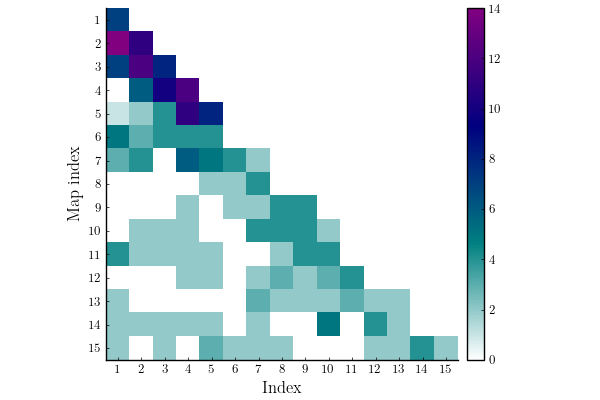

In [9]:
plot(S)
# savefig("Lorenz96_structure.pdf")

Baptista et al.[3] showed that the conditional independence properties of a random variable $\mathsf{X} \in \mathbb{R}^n$ with density $\pi$ are specified by the *Hessian score matrix* $\boldsymbol{\Omega} \in \mathbb{R}^{n \times n}$ defined as:

\begin{equation}
\Omega_{i,j} = \mathrm{E}_{\pi} \left[ |\partial_i\partial_j \log \pi(\boldsymbol{x})|^2  \right] = \int |\partial_i\partial_j \log \pi(\boldsymbol{x})|^2 \pi(\boldsymbol{x}) \; \mathrm{d}\boldsymbol{x}.
\end{equation}

The pullback density $\boldsymbol{S}^{\sharp} \rho$ can be used to approximate the true density $\pi$, where $\rho$ denotes the standard Gaussian distribution of $\mathbb{R}^n$. Thus, the score matrix is estimated by [3]: 
\begin{equation}
\hat{\Omega}_{i,j} = \mathrm{E}_{\pi} \left[ |\partial_i\partial_j \log \boldsymbol{S}^{\sharp} \rho|^2  \right]
\end{equation}

In practice, we use a sampled-based approximation of $\hat{\boldsymbol{\Omega}}$ using samples $\{\boldsymbol{x}^k\}, \; k=1,\ldots, N_e$ of $\pi$ [3]:


\begin{equation}
\hat{\Omega}_{i,j} \approx \sum_{k=1}^{N_e}|\partial_i\partial_j \log \boldsymbol{S}^{\sharp}\rho(\boldsymbol{x}^k )|^2
\end{equation}

The function `hess_x_log_pdf!` computes in-place the Hessian of the log pdf of the pullback density $\boldsymbol{S}^{\sharp} \rho$. You can also use `hess_x_log_pdf`.

In [10]:
Ωhat = zeros(Nx, Nx)
cache = zeros(1, Nx, Nx)
@showprogress for i=1:Ne
    hess_x_log_pdf!(cache, S, X[:,i:i])
    Ωhat .+= copy(cache[1,:,:]).^2
end
rmul!(Ωhat, 1/Ne)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


15×15 Array{Float64,2}:
     5.82811e5   1692.2        17077.9        …  3254.8         213.531
  1692.2            5.40778e5    212.65           991.354         0.0
 17077.9          212.65           6.01159e5      239.532      1717.05
   177.596      17789.0          132.854          436.71          0.0
    28.4903       197.747       7037.17            11.7389       89.9935
    81.2946       422.827       2189.81       …     9.72526      18.2043
   409.502         43.8625         0.810532        80.5917       89.5268
    14.4047         3.31197       46.8318           1.82148     228.542
    36.6251        16.4124         2.482            0.0           0.0
    85.7019        38.5578       210.018         1146.42          0.0
   403.329         18.0389         9.28591    …     0.0           0.0
   328.226        103.09          42.4414        7003.18        505.965
   347.359          0.898695     214.775           62.3933     7153.14
  3254.8          991.354        239.532         

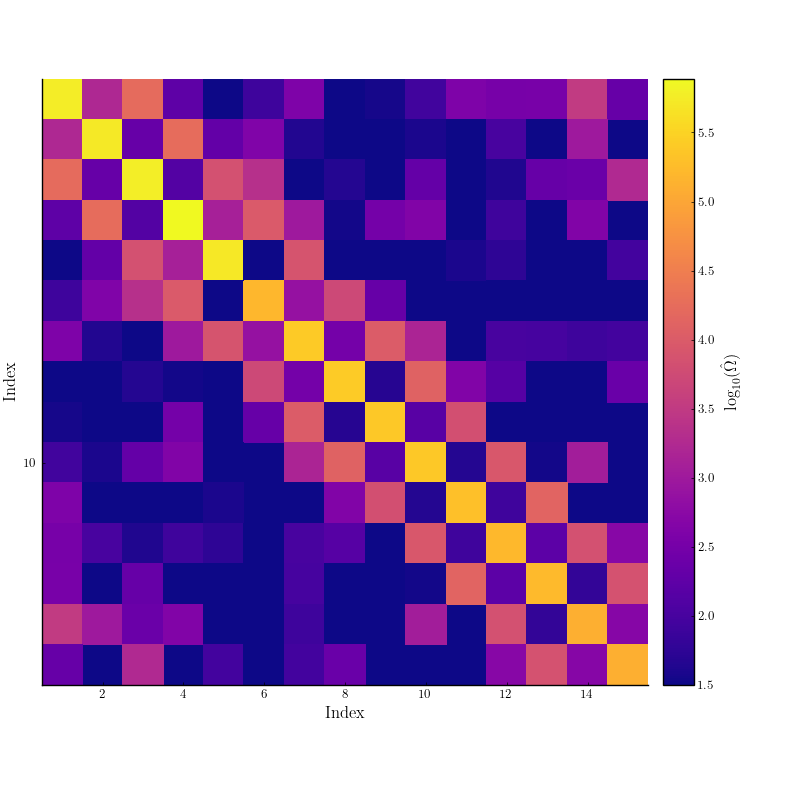

In [11]:
plt = plot(size = (800, 800))

heatmap!(plt,log10.(Ωhat), ratio = 1, yflip = true, 
        colorbar = true, color = :plasma, clim = (1.5, Inf), colorbar_title = L"\log_{10}(\hat{\Omega})",
        xlabel = "Index", ylabel = "Index", background_color_inside = palette(:plasma)[1], 
        yticks = (reverse(collect(0:10:Nx))))
plt